# Sample Project Coronavirus

The goal of this project is to explore a dataset of coronavirus patients to train a model which predicts whether a patient will die or recover from Coronavirus. 

## About the data

The dataset confirmed-positive-on data comes from https://howsmyflattening.ca/#/data/. 

The site is set up by a group of physicians, medical students, computational health researchers, designers and epidemiologists who aim to rapidly filter and present emergent COVID-19 data to help Ontario #FlattenTheCurve. They intend to connect experts and present data in an easy to digest, actionable way to help Ontario's public leaders and individuals act decisively as evidence grows and time ticks by.

### Confirmed positive cases of COVID19 in Ontario

The dataset includes compiled daily reported data from public health units on confirmed positive cases of COVID-19 in Ontario. It includes data on patients from 1st January 2020 to 28th June 2020 and is updated daily. Currently, the dataset inludes data from 37,947 patients. Case data is as initially reported.

The following are the features which we will use for predicting the outcome variable (recovered or diseased).

1. accurate_episode_date - date of diagnosis
2. age_group - categorized to <20, 30s, 40s, 50s, 60s, 70s, 80s or 90s
3. client_gender - female, male, unkown, other,or transgender
4. outbreak_related - Yes or no entry
5. reporting_phu_latitude - Latitude of the reporting public health unit
6. reporting_phu_longitude - longitude of the reporting public health unit




### Preparing the tools

In [2]:
# Exploratory Data Analysis and plotting libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Cleaning with Scikit Learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


# Models from Skikit Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

### Load Data

In [184]:
df = pd.read_csv("confirmed_positive_on.csv", sep =";")
df.shape

(37947, 18)

## Explorative Data Anlysis

In [130]:
df.head()

,id,row_id,accurate_episode_date,age_group,client_gender,case_acquisitionInfo,outcome1,outbreak_related,reporting_phu,reporting_phu_address,reporting_phu_city,reporting_phu_postal_code,reporting_phu_website,reporting_phu_latitude,reporting_phu_longitude,case_reported_date,specimen_reported_date,test_reported_date
0,4066,4066,2020-03-28,20s,FEMALE,Travel,Resolved,NaN,Windsor-Essex County Health Unit,1005 Ouellette Avenue,Windsor,N9A 4J8,www.wechu.org,42.308796,-83.033670,2020-04-03,2020-03-30,2020-04-03
1,1091,1091,2020-03-13,30s,MALE,Travel,Resolved,NaN,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912,2020-03-26,2020-03-17,2020-03-26
2,34119,33188,2020-04-12,20s,FEMALE,No Epi-link,Resolved,NaN,Middlesex-London Health Unit,50 King Street,London,N6A 5L7,www.healthunit.com,42.981468,-81.254016,2020-05-20,2020-05-17,2020-05-20
3,9095,9095,2020-04-12,30s,FEMALE,CC,Resolved,NaN,"Region of Waterloo, Public Health",99 Regina Street South,Waterloo,N2J 4V3,www.regionofwaterloo.ca,43.462876,-80.520913,2020-04-15,2020-04-14,2020-04-15
4,1713,1713,2020-03-23,30s,MALE,CC,Resolved,NaN,Eastern Ontario Health Unit,1000 Pitt Street,Cornwall,K6J 5T1,www.eohu.ca,45.029152,-74.736298,2020-04-01,2020-03-24,2020-04-01


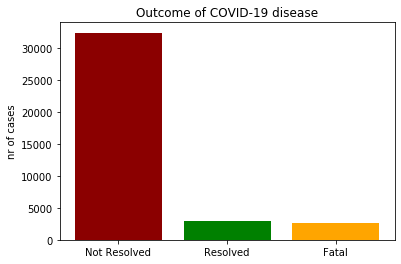

In [131]:
fig, ax = plt.subplots()
ax.bar(x = list(set(df["outcome1"])), height = df["outcome1"].value_counts(), color=['darkred', 'g', 'orange'])
ax.set_ylabel("nr of cases")
ax.set_title("Outcome of COVID-19 disease")

plt.show()



In [185]:
df["outcome1"].value_counts(normalize = True)

Resolved        0.854033
Fatal           0.075895
Not Resolved    0.070071
Name: outcome1, dtype: float64

The dataset is highly unbalanced with approximately 85 % recoveries, 8 % fatal outcomes and 7 % not yet resolved cases. For now, we shall exclude unresolved cases from our analysis and label "Fatal" outcome as 1 and Resolved as 0.

In [186]:
df.drop(df[df["outcome1"] == "Not Resolved"].index, inplace = True)
df["outcome1"].replace({"Fatal": 1, "Resolved": 0}, inplace = True)

In [187]:
df["outcome1"].value_counts(normalize = True)

0    0.918386
1    0.081614
Name: outcome1, dtype: float64

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35288 entries, 0 to 37946
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         35288 non-null  int64  
 1   row_id                     35288 non-null  int64  
 2   accurate_episode_date      35286 non-null  object 
 3   age_group                  35288 non-null  object 
 4   client_gender              35288 non-null  object 
 5   case_acquisitionInfo       35288 non-null  object 
 6   outcome1                   35288 non-null  int64  
 7   outbreak_related           14676 non-null  object 
 8   reporting_phu              35288 non-null  object 
 9   reporting_phu_address      35288 non-null  object 
 10  reporting_phu_city         35288 non-null  object 
 11  reporting_phu_postal_code  35288 non-null  object 
 12  reporting_phu_website      35288 non-null  object 
 13  reporting_phu_latitude     35288 non-null  flo

### Cleaning features

In [136]:
df.isna().sum()

id                               0
row_id                           0
accurate_episode_date            2
age_group                        0
client_gender                    0
case_acquisitionInfo             0
outcome1                         0
outbreak_related             20612
reporting_phu                    0
reporting_phu_address            0
reporting_phu_city               0
reporting_phu_postal_code        0
reporting_phu_website            0
reporting_phu_latitude           0
reporting_phu_longitude          0
case_reported_date               0
specimen_reported_date         329
test_reported_date             447
dtype: int64

### COVID 19 outcome according to Gender

In [137]:
df.client_gender.value_counts()

FEMALE         19006
MALE           16005
UNKNOWN          262
OTHER              8
TRANSGENDER        7
Name: client_gender, dtype: int64

In [138]:
pd.crosstab(df.outcome1, df.client_gender)

client_gender,FEMALE,MALE,OTHER,TRANSGENDER,UNKNOWN
outcome1,,,,,
0,17462,14712,8,6,220
1,1544,1293,0,1,42


In [140]:
female_fatal = sum((df.client_gender == "FEMALE") & (df.outcome1 == 1))
female_resolved = sum((df.client_gender == "FEMALE") & (df.outcome1 == 0))
mortality_rate_female = female_fatal / female_resolved
mortality_rate_female


0.08842057038139961

In [141]:
male_fatal = sum((df.client_gender == "MALE") & (df.outcome1 == 1))
male_resolved = sum((df.client_gender == "MALE") & (df.outcome1 == 0))
mortality_rate_male = male_fatal / male_resolved
mortality_rate_male

0.08788743882544861

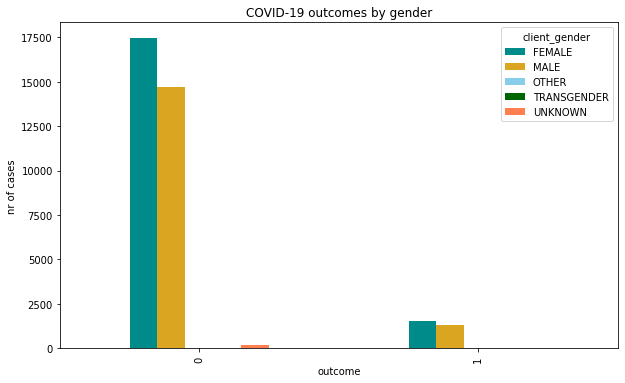

In [144]:
# Plotting the data
pd.crosstab(df.outcome1, df.client_gender).plot(kind="bar", figsize=(10,6), color=["darkcyan", "goldenrod", "skyblue", "darkgreen", "coral"])

plt.title("COVID-19 outcomes by gender")
plt.xlabel("outcome")
plt.ylabel("nr of cases");

### Age for COVID-19 outcomes

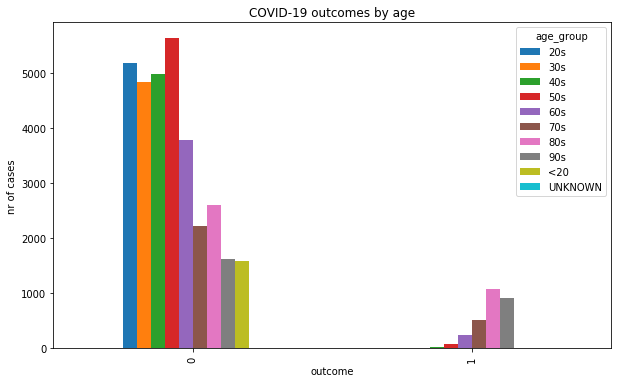

In [145]:
pd.crosstab(df.outcome1, df.age_group).plot(kind="bar", figsize=(10,6))

plt.title("COVID-19 outcomes by age")
plt.xlabel("outcome")
plt.ylabel("nr of cases");

### Correlation Analysis of Independent Data

In [66]:
corr_matrix = df.corr()
corr_matrix

,id,row_id,reporting_phu_latitude,reporting_phu_longitude
id,1.000000,0.998763,-0.008555,0.036464
row_id,0.998763,1.000000,-0.009167,0.037896
reporting_phu_latitude,-0.008555,-0.009167,1.000000,0.463740
reporting_phu_longitude,0.036464,0.037896,0.463740,1.000000


## Modeling

In [127]:
df.head()


,accurate_episode_date,age_group,client_gender,case_acquisitionInfo,outcome1,outbreak_related,reporting_phu,reporting_phu_city,reporting_phu_postal_code,reporting_phu_latitude,reporting_phu_longitude,case_reported_date,test_reported_date
0,2020-03-28,20s,FEMALE,Travel,Resolved,NaN,Windsor-Essex County Health Unit,Windsor,N9A 4J8,42.308796,-83.033670,2020-04-03,2020-04-03
1,2020-03-13,30s,MALE,Travel,Resolved,NaN,Ottawa Public Health,Ottawa,K2G 6J8,45.345665,-75.763912,2020-03-26,2020-03-26
2,2020-04-12,20s,FEMALE,No Epi-link,Resolved,NaN,Middlesex-London Health Unit,London,N6A 5L7,42.981468,-81.254016,2020-05-20,2020-05-20
3,2020-04-12,30s,FEMALE,CC,Resolved,NaN,"Region of Waterloo, Public Health",Waterloo,N2J 4V3,43.462876,-80.520913,2020-04-15,2020-04-15
4,2020-03-23,30s,MALE,CC,Resolved,NaN,Eastern Ontario Health Unit,Cornwall,K6J 5T1,45.029152,-74.736298,2020-04-01,2020-04-01


Split data into target variable ("outcome1") and predictor variables. 

### Transform the features

In [198]:
df.dtypes

id                             int64
row_id                         int64
accurate_episode_date         object
age_group                     object
client_gender                 object
case_acquisitionInfo          object
outcome1                      object
outbreak_related              object
reporting_phu                 object
reporting_phu_address         object
reporting_phu_city            object
reporting_phu_postal_code     object
reporting_phu_website         object
reporting_phu_latitude       float64
reporting_phu_longitude      float64
case_reported_date            object
specimen_reported_date        object
test_reported_date            object
dtype: object

In [202]:
df.isna().sum()

id                               0
row_id                           0
accurate_episode_date            0
age_group                        0
client_gender                    0
case_acquisitionInfo             0
outcome1                         0
outbreak_related             20611
reporting_phu                    0
reporting_phu_address            0
reporting_phu_city               0
reporting_phu_postal_code        0
reporting_phu_website            0
reporting_phu_latitude           0
reporting_phu_longitude          0
case_reported_date               0
specimen_reported_date         329
test_reported_date             447
dtype: int64

We convert dates into days from the date of first reported case.

In [188]:
from datetime import date
from datetime import datetime

d0 = pd.to_datetime('2020-01-01')

df["accurate_episode_date"] = pd.to_datetime(df["accurate_episode_date"])
df["case_reported_date"] = pd.to_datetime(df["case_reported_date"])
df["test_reported_date"] = pd.to_datetime(df["test_reported_date"])

df["accurate_episode_date"] = (df["accurate_episode_date"] - d0).dt.days
df["case_reported_date"] = (df["case_reported_date"] - d0).dt.days
df["test_reported_date"] = (df["test_reported_date"] - d0).dt.days

Since there is only one missing value for accurate_episode_date, we exclude that data point.

In [189]:
df.dropna(subset = ["accurate_episode_date"], inplace = True)

In [190]:
df.drop(columns=["id", "row_id", "case_acquisitionInfo", "reporting_phu_address", "reporting_phu_website", "specimen_reported_date"], axis =1, inplace =True)

In [191]:
df.head()

,accurate_episode_date,age_group,client_gender,outcome1,outbreak_related,reporting_phu,reporting_phu_city,reporting_phu_postal_code,reporting_phu_latitude,reporting_phu_longitude,case_reported_date,test_reported_date
0,87.0,20s,FEMALE,0,NaN,Windsor-Essex County Health Unit,Windsor,N9A 4J8,42.308796,-83.033670,93,93.0
1,72.0,30s,MALE,0,NaN,Ottawa Public Health,Ottawa,K2G 6J8,45.345665,-75.763912,85,85.0
2,102.0,20s,FEMALE,0,NaN,Middlesex-London Health Unit,London,N6A 5L7,42.981468,-81.254016,140,140.0
3,102.0,30s,FEMALE,0,NaN,"Region of Waterloo, Public Health",Waterloo,N2J 4V3,43.462876,-80.520913,105,105.0
4,82.0,30s,MALE,0,NaN,Eastern Ontario Health Unit,Cornwall,K6J 5T1,45.029152,-74.736298,91,91.0


### Train test split

In [192]:
X = df.drop("outcome1", axis = 1)
y = df["outcome1"]

In [151]:
X.head()

,accurate_episode_date,age_group,client_gender,outbreak_related,reporting_phu,reporting_phu_city,reporting_phu_postal_code,reporting_phu_latitude,reporting_phu_longitude,case_reported_date,test_reported_date
0,87.0,20s,FEMALE,NaN,Windsor-Essex County Health Unit,Windsor,N9A 4J8,42.308796,-83.033670,93,93.0
1,72.0,30s,MALE,NaN,Ottawa Public Health,Ottawa,K2G 6J8,45.345665,-75.763912,85,85.0
2,102.0,20s,FEMALE,NaN,Middlesex-London Health Unit,London,N6A 5L7,42.981468,-81.254016,140,140.0
3,102.0,30s,FEMALE,NaN,"Region of Waterloo, Public Health",Waterloo,N2J 4V3,43.462876,-80.520913,105,105.0
4,82.0,30s,MALE,NaN,Eastern Ontario Health Unit,Cornwall,K6J 5T1,45.029152,-74.736298,91,91.0


In [152]:
y

0        0
1        0
2        0
3        0
4        0
        ..
37942    0
37943    0
37944    0
37945    0
37946    0
Name: outcome1, Length: 35286, dtype: int64

In [193]:
np.random.seed(7)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   test_size = 0.2)

In [194]:
print(X_train.shape, 
     X_test.shape, 
     y_train.shape, 
     y_test.shape, 
     sep="\n")

(28228, 11)
(7058, 11)
(28228,)
(7058,)


In [155]:
y_train.value_counts()

0    25939
1     2289
Name: outcome1, dtype: int64

In [195]:
# custom transformer that assigns numbers to the age_groups
from sklearn.base import BaseEstimator, TransformerMixin
class CustomNumericalTransformer( BaseEstimator, TransformerMixin ):
    def __init__(self):
        return None
        
    def fit(self, X, y = None):
        return self
    
    
    def transform(self, X, y=None):
        #print("transform called")
        transformed_X = pd.DataFrame(X.copy())
        #print(type(transformed_X))
        #print(transformed_X.shape)
        transformed_X = transformed_X.replace({'80s':80, '20s':20, '<20':10, '60s':60, '50s':50, '70s':70, '30s':30, '40s':40, '90s':90})

        #print(transformed_X)
        return transformed_X



In [196]:
# Define different features and transformer pipeline
categorical_features = ["client_gender", "outbreak_related", "reporting_phu", "reporting_phu_city", "reporting_phu_postal_code"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

numeric_features = ["age_group"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(missing_values="UNKNOWN",strategy="most_frequent")),
    ("num_transformer", CustomNumericalTransformer() )
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features)])



### Fit models

To begin with, we try out KNN, Logistic Regression and Random Forest. 

In [197]:
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        clf = Pipeline(steps=[("preprocessor", preprocessor),
                        ("model", model)])
        clf.fit(X_train, y_train)
        
        # Evaluate the model and append its score to model_scores
        model_scores[name] = clf.score(X_test, y_test)
    return model_scores

In [198]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'KNN': 0.9018135449135732,
 'Logistic Regression': 0.9149900821762539,
 'Random Forest': 0.9128648342306602}

## Hyperparameter Tuning

### Tuning KNN by hand

In [218]:
# Create a list of train scores
train_scores = []

# Create a list of test scores
test_scores = []

# Create a list of different values for n_neighbors
neighbors = [2,5,10,20] # 1 to 20

# Setup algorithm
knn = KNeighborsClassifier()

# Loop through different neighbors values
for i in neighbors:
    knn.set_params(n_neighbors = i) # set neighbors value
    
    # Fit the algorithm
    #clf = Pipeline(steps=[("preprocessor", preprocessor),
                        #("model", knn)])
    knn.fit(X_train, y_train)
    
    # Update the training scores
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores
    test_scores.append(knn.score(X_test, y_test))

In [219]:
test_scores

[0.9054973080192689, 0.9018135449135732, 0.9132898838197789, 0.914706715783508]

Maximum KNN score on the test data: 91.47%


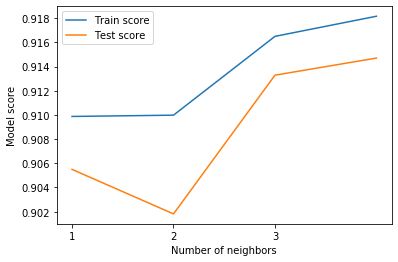

In [220]:
plt.plot(range(1,5), train_scores, label="Train score")
plt.plot(range(1,5), test_scores, label="Test score")
plt.xticks(np.arange(1, 4, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

### Tuning Logistic Regression and RandomForestClassifier using RandomizedSearchCV

In [205]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [207]:
# Setup random seed
np.random.seed(42)

#X_train = preprocessor.fit_transform(X_train)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.5s finished


In [168]:
rs_log_reg.best_params_


{'solver': 'liblinear', 'C': 0.03359818286283781}

In [200]:
X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

In [209]:
rs_log_reg.score(X_test, y_test)


0.9156984981581184

In [221]:
# Random Forest Classifier
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model
rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.3min finished


In [97]:
# Find the best parameters
rs_rf.best_params_

{'n_estimators': 910,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_depth': 10}

In [98]:
# Evaluate the randomized search random forest model
rs_rf.score(X_test, y_test)

0.8534721307155093

## Further evaluation metrics

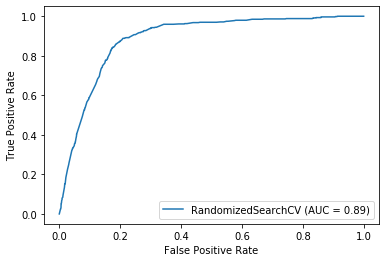

In [222]:
# ROC Curve
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rs_rf, X_test, y_test);

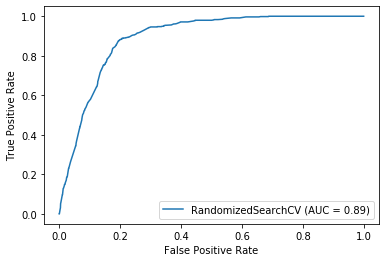

In [210]:
plot_roc_curve(rs_log_reg, X_test, y_test);

In [ ]:
plot_roc_curve(rs_rf);

Confusion matrix, without normalization
[[6449   18]
 [ 577   14]]
Normalized confusion matrix
[[0.99721664 0.00278336]
 [0.97631134 0.02368866]]


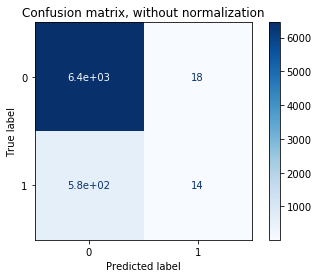

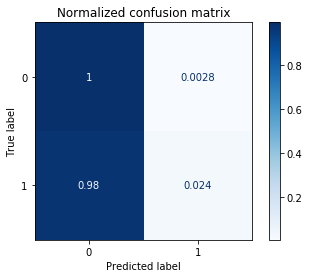

In [212]:
# plot_confusion_matrix for logistic regression
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rs_log_reg, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix, without normalization
[[6456   11]
 [ 583    8]]
Normalized confusion matrix
[[0.99829906 0.00170094]
 [0.98646362 0.01353638]]


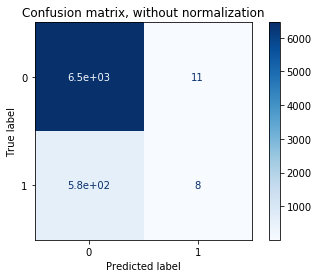

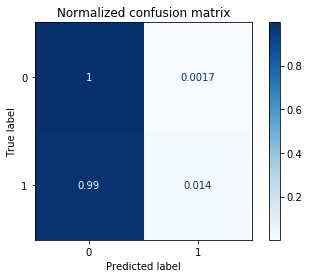

In [223]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rs_rf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [215]:
# classification report
y_preds = rs_log_reg.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6467
           1       0.44      0.02      0.04       591

    accuracy                           0.92      7058
   macro avg       0.68      0.51      0.50      7058
weighted avg       0.88      0.92      0.88      7058



In [224]:
# classification report
y_preds = rs_rf.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6467
           1       0.42      0.01      0.03       591

    accuracy                           0.92      7058
   macro avg       0.67      0.51      0.49      7058
weighted avg       0.88      0.92      0.88      7058

